In [1]:
!nvidia-smi

Thu May  2 16:28:10 2024       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.14              Driver Version: 550.54.14      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA RTX A5000               Off |   00000000:41:00.0 Off |                  Off |
| 30%   36C    P8             17W /  230W |    1281MiB /  24564MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader
from torchvision import transforms
from torchvision.datasets import ImageFolder
from datasets import load_dataset
import torch.optim as optim

import torchvision.datasets as datasets
import torchvision.transforms as transforms
from torchvision.utils import make_grid

resolution = 256
augmentations = transforms.Compose(
    [
        transforms.Resize((256, 256)),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.5], [0.5]),
    ]
)
# augmentations = transforms.Compose(
#     [
#         transforms.Resize(resolution, interpolation=transforms.InterpolationMode.BILINEAR),
#         transforms.RandomCrop(resolution),
#         transforms.Lambda(lambda x: x),
#         transforms.ToTensor(),
#         transforms.Normalize([0.5], [0.5]),
#     ]
# )

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
train_batch_size = 4
eval_batch_size = 8
train_dataset_path = "ddpm-data/summer2winter_yosemite/train"
eval_dataset_path = "ddpm-data/summer2winter_yosemite/test"
train_ds = ImageFolder(root=train_dataset_path, transform=augmentations)
eval_ds = ImageFolder(root=eval_dataset_path, transform=augmentations)

print(f"Train Dataset size: {len(train_ds)}")
print(f"Eval Dataset size: {len(eval_ds)}")

train_dataloader = torch.utils.data.DataLoader(
    train_ds, batch_size=train_batch_size, shuffle=True, num_workers=0
)
eval_dataloader = torch.utils.data.DataLoader(
    eval_ds, batch_size=eval_batch_size, shuffle=False, num_workers=0
)

/nfshomes/skarki/scratch/miniconda3/envs/llm/lib/python3.9/site-packages/transformers/utils/generic.py:485: UserWarning: torch.utils._pytree._register_pytree_node is deprecated. Please use torch.utils._pytree.register_pytree_node instead.
  _torch_pytree._register_pytree_node(


Train Dataset size: 2193
Eval Dataset size: 547


In [3]:
num_epochs = 20

num_hiddens = 128
num_residual_hiddens = 32
num_residual_layers = 2

embedding_dim = 64
num_embeddings = 512

commitment_cost = 0.25

decay = 0.99

learning_rate = 5e-4

In [5]:
from vqvae import VQVAE
vae_model = VQVAE(num_hiddens, num_residual_layers, num_residual_hiddens,
              num_embeddings, embedding_dim, 
              commitment_cost, decay).to(device)
optimizer = optim.Adam(vae_model.parameters(), lr=learning_rate, amsgrad=False)

In [6]:
mean = 0.
std = 0.
nb_samples = 0.
for data, _ in train_dataloader:
    batch_samples = data.size(0)
    data = data.view(batch_samples, data.size(1), -1)
    mean += data.mean(2).sum(0)
    std += data.std(2).sum(0)
    nb_samples += batch_samples

mean /= nb_samples
std /= nb_samples

In [7]:
data_variance = torch.sqrt(std).to(device).mean()
data_variance

tensor(0.6910, device='cuda:0')

In [ ]:
from tqdm.auto import tqdm, trange
from PIL import Image
from torchvision.utils import save_image

step = 0
save_image_every = 200

def show(img):
    npimg = img.numpy()
    plt.figure(figsize = (30,20))
    fig = plt.imshow(np.transpose(npimg, (1,2,0)), interpolation='nearest',)
    fig.axes.get_xaxis().set_visible(False)
    fig.axes.get_yaxis().set_visible(False)


def save_img(img, fpath):
    save_image(img, fpath)
    # npimg = img.numpy()
    # plt.figure(figsize = (30,20))
    # plt.imsave(fpath,np.transpose(npimg, (1,2,0)))

vae_model.train()
with trange(num_epochs, desc="Epoch") as ep_progress:
    for epoch in ep_progress:
        train_res_recon_error = []
        train_res_perplexity = []
        with tqdm(train_dataloader, desc="Train") as tr_progress:
            for data, _ in tr_progress:
                data = data.to(device)
                optimizer.zero_grad()
            
                vq_loss, data_recon, perplexity = vae_model(data)
                recon_error = F.mse_loss(data_recon, data) / data_variance
                loss = recon_error + vq_loss
                loss.backward()
            
                optimizer.step()
                
                train_res_recon_error.append(recon_error.item())
                train_res_perplexity.append(perplexity.item())
                tr_progress.set_postfix(recon_error=recon_error.item(), perplexity=perplexity.item())

                if step % save_image_every == 0:
                    vae_model.eval()
                    (valid_originals, _) = next(iter(eval_dataloader))
                    valid_originals = valid_originals.to(device)
                    
                    vq_output_eval = vae_model._pre_vq_conv(vae_model._encoder(valid_originals))
                    _, valid_quantize, _, _ = vae_model._vq_vae(vq_output_eval)
                    valid_reconstructions = vae_model._decoder(valid_quantize)
                    grid = make_grid(valid_reconstructions.cpu().data) + 0.5

                    fname = f"vqvae-samples-yosemite-test/{epoch}_{step}.jpeg"
                    save_img(grid, fname)
                    vae_model.train()
                step += 1
                    
            ep_progress.set_postfix(recon_error=np.mean(train_res_recon_error[-100:]), perplexity=np.mean(train_res_perplexity[-100:]))
            

Epoch:   0%|          | 0/20 [00:00<?, ?it/s]

Train:   0%|          | 0/549 [00:00<?, ?it/s]

Train:   0%|          | 0/549 [00:00<?, ?it/s]

Train:   0%|          | 0/549 [00:00<?, ?it/s]

In [11]:
torch.save(vae_model.state_dict(), f"vqvae-yosemite-latest.pth")

In [12]:
vae_model.train()
with trange(num_epochs, desc="Epoch") as ep_progress:
    for epoch in ep_progress:
        train_res_recon_error = []
        train_res_perplexity = []
        with tqdm(train_dataloader, desc="Train") as tr_progress:
            for data, _ in tr_progress:
                data = data.to(device)
                optimizer.zero_grad()
            
                vq_loss, data_recon, perplexity = vae_model(data)
                recon_error = F.mse_loss(data_recon, data) / data_variance
                loss = recon_error + vq_loss
                loss.backward()
            
                optimizer.step()
                
                train_res_recon_error.append(recon_error.item())
                train_res_perplexity.append(perplexity.item())
                tr_progress.set_postfix(recon_error=recon_error.item(), perplexity=perplexity.item())

                if step % save_image_every == 0:
                    vae_model.eval()
                    (valid_originals, _) = next(iter(eval_dataloader))
                    valid_originals = valid_originals.to(device)
                    
                    vq_output_eval = vae_model._pre_vq_conv(vae_model._encoder(valid_originals))
                    _, valid_quantize, _, _ = vae_model._vq_vae(vq_output_eval)
                    valid_reconstructions = vae_model._decoder(valid_quantize)
                    grid = make_grid(valid_reconstructions.cpu().data) + 0.5

                    fname = f"vqvae-samples-yosemite/{epoch}_{step}.jpeg"
                    save_img(grid, fname)
                    vae_model.train()
                step += 1
                    
            ep_progress.set_postfix(recon_error=np.mean(train_res_recon_error[-100:]), perplexity=np.mean(train_res_perplexity[-100:]))
          

Epoch:   0%|          | 0/20 [00:00<?, ?it/s]

Train:   0%|          | 0/549 [00:00<?, ?it/s]

Train:   0%|          | 0/549 [00:00<?, ?it/s]

Train:   0%|          | 0/549 [00:00<?, ?it/s]

Train:   0%|          | 0/549 [00:00<?, ?it/s]

Train:   0%|          | 0/549 [00:00<?, ?it/s]

Train:   0%|          | 0/549 [00:00<?, ?it/s]

Train:   0%|          | 0/549 [00:00<?, ?it/s]

Train:   0%|          | 0/549 [00:00<?, ?it/s]

Train:   0%|          | 0/549 [00:00<?, ?it/s]

Train:   0%|          | 0/549 [00:00<?, ?it/s]

Train:   0%|          | 0/549 [00:00<?, ?it/s]

Train:   0%|          | 0/549 [00:00<?, ?it/s]

Train:   0%|          | 0/549 [00:00<?, ?it/s]

Train:   0%|          | 0/549 [00:00<?, ?it/s]

Train:   0%|          | 0/549 [00:00<?, ?it/s]

Train:   0%|          | 0/549 [00:00<?, ?it/s]

Train:   0%|          | 0/549 [00:00<?, ?it/s]

Train:   0%|          | 0/549 [00:00<?, ?it/s]

Train:   0%|          | 0/549 [00:00<?, ?it/s]

Train:   0%|          | 0/549 [00:00<?, ?it/s]

In [13]:
torch.save(vae_model.state_dict(), f"vqvae-yosemite-latest.pth")

In [14]:
vae_model.eval()

(valid_originals, _) = next(iter(eval_dataloader))
(valid_originals, _) = next(iter(eval_dataloader))
valid_originals = valid_originals.to(device)

vq_output_eval = vae_model._pre_vq_conv(vae_model._encoder(valid_originals))
_, valid_quantize, _, _ = vae_model._vq_vae(vq_output_eval)
valid_reconstructions = vae_model._decoder(valid_quantize)
print(valid_quantize.shape)

torch.Size([8, 64, 64, 64])


In [15]:
(train_originals, _) = next(iter(train_dataloader))
train_originals = train_originals.to(device)
_, train_reconstructions, _, _ = vae_model._vq_vae(train_originals)


In [16]:
def show(img):
    print(type(img))
    npimg = img.numpy()
    plt.figure(figsize = (30,20))
    fig = plt.imshow(np.transpose(npimg, (1,2,0)), interpolation='nearest',)
    fig.axes.get_xaxis().set_visible(False)
    fig.axes.get_yaxis().set_visible(False)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


<class 'torch.Tensor'>


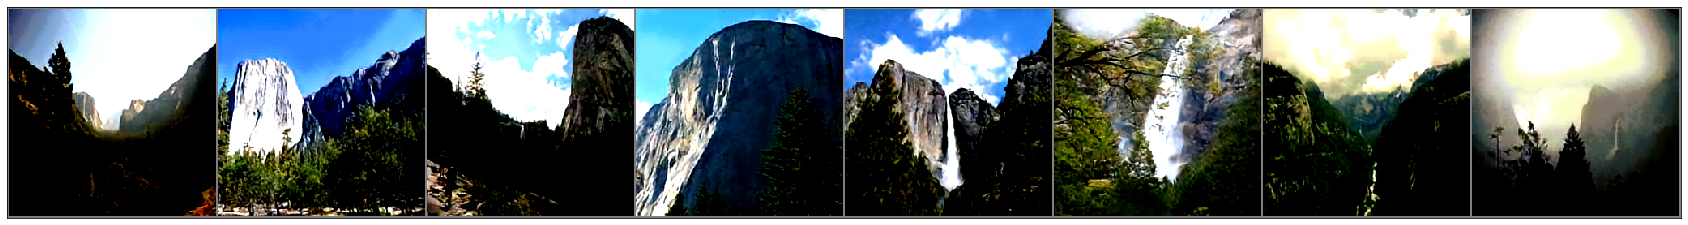

In [17]:
show(make_grid(valid_reconstructions.cpu().data)+0.5, )

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


<class 'torch.Tensor'>


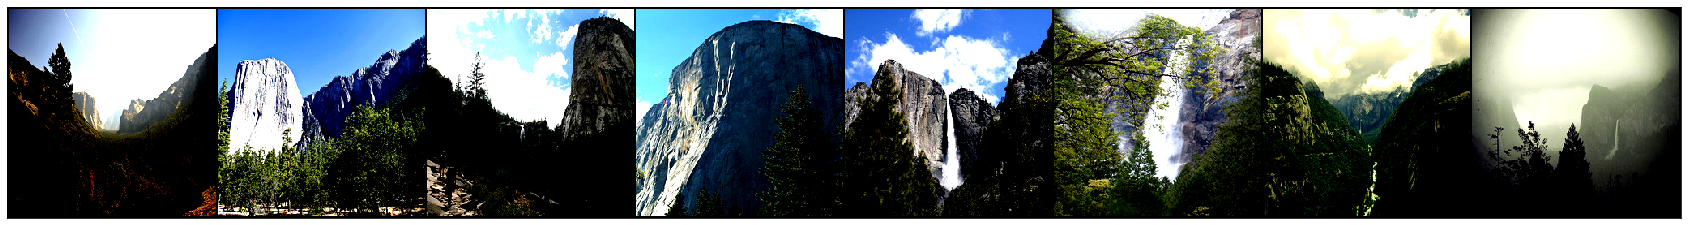

In [18]:
show(make_grid(valid_originals.cpu()+0.5))

In [ ]:
################## TRAIN diffusion

In [21]:
class ConvBlock(nn.Module):
    def __init__(self, input_channels: int, output_channels: int, use_residual: bool = False) -> None:
        super().__init__()
        self.match_channels = input_channels == output_channels
        self.use_residual = use_residual
        self.first_conv = nn.Sequential(
            nn.Conv2d(input_channels, output_channels, 3, 1, 1),
            nn.BatchNorm2d(output_channels),
            nn.GELU(),
        )
        self.second_conv = nn.Sequential(
            nn.Conv2d(output_channels, output_channels, 3, 1, 1),
            nn.BatchNorm2d(output_channels),
            nn.GELU(),
        )

    def forward(self, input_tensor: torch.Tensor) -> torch.Tensor:
        if self.use_residual:
            conv1_output = self.first_conv(input_tensor)
            conv2_output = self.second_conv(conv1_output)
            if self.match_channels:
                output = input_tensor + conv2_output
            else:
                output = conv1_output + conv2_output
            return output / 1.414
        else:
            conv1_output = self.first_conv(input_tensor)
            return self.second_conv(conv1_output)


class DownBlock(nn.Module):
    def __init__(self, input_channels, output_channels):
        super().__init__()
        modules = [ConvBlock(input_channels, output_channels), nn.MaxPool2d(2)]
        self.sequence = nn.Sequential(*modules)

    def forward(self, input_tensor):
        return self.sequence(input_tensor)


class UpBlock(nn.Module):
    def __init__(self, input_channels, output_channels):
        super().__init__()
        modules = [
            nn.ConvTranspose2d(input_channels, output_channels, 2, 2),
            ConvBlock(output_channels, output_channels),
            ConvBlock(output_channels, output_channels),
        ]
        self.sequence = nn.Sequential(*modules)

    def forward(self, input_tensor, concatenated_tensor):
        combined_tensor = torch.cat((input_tensor, concatenated_tensor), 1)
        out =  self.sequence(combined_tensor)
        # if torch.isnan(input_tensor).any():
        #     print("NaN detected in input tensor")
        # if torch.isnan(concatenated_tensor).any():
        #     print("NaN detected in concat tensor")
        # if torch.isnan(combined_tensor).any():
        #     print("NaN detected in combined tensor")
        # if torch.isnan(out).any():
        #     print("NaN detected in upsampled tensor")
        return out


class FCBlock(nn.Module):
    def __init__(self, input_dimension, embedding_dimension):
        super().__init__()
        self.input_dimension = input_dimension
        modules = [
            nn.Linear(input_dimension, embedding_dimension),
            nn.GELU(),
            nn.Linear(embedding_dimension, embedding_dimension),
        ]
        self.sequence = nn.Sequential(*modules)

    def forward(self, input_tensor):
        reshaped_tensor = input_tensor.view(-1, self.input_dimension)
        return self.sequence(reshaped_tensor)


class EnhancedUnet(nn.Module):
    def __init__(self, input_channels, feature_dim = 256, num_classes=10):
        super().__init__()
        self.input_channels = input_channels
        self.feature_dim = feature_dim
        self.num_classes = num_classes

        self.initial_conv = ConvBlock(input_channels, feature_dim, use_residual=True)

        self.down_block1 = DownBlock(feature_dim, feature_dim)
        self.down_block2 = DownBlock(feature_dim, 2 * feature_dim)

        self.flatten = nn.Sequential(nn.AvgPool2d(7), nn.GELU())

        self.temporal_embedding1 = FCBlock(1, 2*feature_dim)
        self.temporal_embedding2 = FCBlock(1, feature_dim)
        self.context_embedding1 = FCBlock(num_classes, 2*feature_dim)
        self.context_embedding2 = FCBlock(num_classes, feature_dim)

        self.up_sample = nn.Sequential(
            nn.ConvTranspose2d(2 * feature_dim, 2 * feature_dim, kernel_size=16, stride=8, padding=4),
            nn.GroupNorm(8, 2 * feature_dim),
            nn.ReLU(),
        )

        self.up_block1 = UpBlock(4 * feature_dim, feature_dim)
        self.up_block2 = UpBlock(2 * feature_dim, feature_dim)
        self.final_conv = nn.Sequential(
            nn.Conv2d(2 * feature_dim, feature_dim, 3, 1, 1),
            nn.GroupNorm(8, feature_dim),
            nn.ReLU(),
            nn.Conv2d(feature_dim, self.input_channels, 3, 1, 1),
        )

    def forward(self, input_tensor, context, time_step, mask):
        processed_tensor = self.initial_conv(input_tensor)
        if torch.isnan(processed_tensor).any():
            print("NaNs after initial_conv")
            
        down1_output = self.down_block1(processed_tensor)
        down2_output = self.down_block2(down1_output)
        hidden_vector = self.flatten(down2_output)

        if torch.isnan(hidden_vector).any():
            print("NaNs after hidden vector flatten")

        
        context_onehot = nn.functional.one_hot(context, num_classes=self.num_classes).type(torch.float)
        masked_context = mask[:, None].repeat(1, self.num_classes)
        masked_context = (-1 * (1 - masked_context))
        masked_context = context_onehot * masked_context

        if torch.isnan(masked_context).any():
            print("NaNs in masked_context")
        
        context_emb1 = self.context_embedding1(masked_context).view(-1, self.feature_dim * 2, 1, 1)
        time_emb1 = self.temporal_embedding1(time_step).view(-1, self.feature_dim * 2, 1, 1)
        
        if torch.isnan(context_emb1).any() or torch.isnan(time_emb1).any():
            print("NaNs in embeddings context emb1")
            
        context_emb2 = self.context_embedding2(masked_context).view(-1, self.feature_dim, 1, 1)
        time_emb2 = self.temporal_embedding2(time_step).view(-1, self.feature_dim, 1, 1)

        if torch.isnan(context_emb2).any() or torch.isnan(time_emb2).any():
            print("NaNs in embeddings context emb2")
             
        up1_output = self.up_sample(hidden_vector)
        up2_output = self.up_block1(context_emb1 * up1_output + time_emb1, down2_output)
        final_output = self.up_block2(context_emb2 * up2_output + time_emb2, down1_output)
        
        if torch.isnan(hidden_vector).any():
            print("NaNs in up1_output hidden vector")
        if torch.isnan(up1_output).any():
            print("NaNs in up1_output")
        if torch.isnan(up2_output).any():
            print("NaNs in up2_output")
        if torch.isnan(final_output).any():
            print("NaNs in final_output")
        return self.final_conv(torch.cat((final_output, processed_tensor), 1))


def schedule_ddpm(beta_start, beta_end, total_steps):
    beta_range = (beta_end - beta_start) * torch.arange(0, total_steps + 1, dtype=torch.float32) / total_steps + beta_start
    sqrt_beta = torch.sqrt(beta_range)
    alpha = 1 - beta_range
    log_alpha = torch.log(alpha)
    cumulative_alpha = torch.cumsum(log_alpha, dim=0).exp()

    sqrt_cum_alpha = torch.sqrt(cumulative_alpha)
    one_over_sqrt_alpha = 1 / torch.sqrt(alpha)

    sqrt_one_minus_cum_alpha = torch.sqrt(1 - cumulative_alpha)
    one_minus_alpha_over_sqrt_one_minus_cum_alpha = (1 - alpha) / sqrt_one_minus_cum_alpha

    return {
        "alpha": alpha,
        "one_over_sqrt_alpha": one_over_sqrt_alpha,
        "sqrt_beta": sqrt_beta,
        "cumulative_alpha": cumulative_alpha,
        "sqrt_cum_alpha": sqrt_cum_alpha,
        "sqrt_one_minus_cum_alpha": sqrt_one_minus_cum_alpha,
        "one_minus_alpha_over_sqrt_one_minus_cum_alpha": one_minus_alpha_over_sqrt_one_minus_cum_alpha,
    }


class DiffusionModel(nn.Module):
    def __init__(self, model, betas, num_steps, device, dropout_probability=0.1):
        super().__init__()
        self.model = model.to(device)
        for key, value in schedule_ddpm(betas[0], betas[1], num_steps).items():
            self.register_buffer(key, value)

        self.num_steps = num_steps
        self.device = device
        self.dropout_probability = dropout_probability
        self.mse_loss = nn.MSELoss()

    def forward(self, input_tensor, context):
        time_indices = torch.randint(1, self.num_steps+1, (input_tensor.shape[0],)).to(self.device)
        random_noise = torch.randn_like(input_tensor)

        processed_tensor = (
            self.sqrt_cum_alpha[time_indices, None, None, None] * input_tensor
            + self.sqrt_one_minus_cum_alpha[time_indices, None, None, None] * random_noise
        )
        context_dropout = torch.bernoulli(torch.zeros_like(context)+self.dropout_probability).to(self.device)

        return self.mse_loss(random_noise, self.model(processed_tensor, context, time_indices / self.num_steps, context_dropout))

    def sample(self, sample_count, dimensions, device, guidance_weight = 0.0):
        initial_noise = torch.randn(sample_count, *dimensions).to(device)
        context_indices = torch.arange(0, self.model.num_classes).to(device)
        context_indices = context_indices.repeat(int(sample_count / context_indices.shape[0]))

        context_mask = torch.zeros_like(context_indices).to(device)

        context_indices = context_indices.repeat(2)
        context_mask = context_mask.repeat(2)
        context_mask[sample_count:] = 1.0

        stored_samples = []
        for time_step in range(self.num_steps, 0, -1):
            print(f'Sampling timestep {time_step}',end='\r')
            time_tensor = torch.tensor([time_step / self.num_steps]).to(device)
            time_tensor = time_tensor.repeat(sample_count, 1, 1, 1)

            initial_noise = initial_noise.repeat(2, 1, 1, 1)
            time_tensor = time_tensor.repeat(2, 1, 1, 1)

            additional_noise = torch.randn(sample_count, *dimensions).to(device) if time_step > 1 else 0

            predicted_noise = self.model(initial_noise, context_indices, time_tensor, context_mask)
            predicted_noise1 = predicted_noise[:sample_count]
            predicted_noise2 = predicted_noise[sample_count:]
            predicted_noise = (1 + guidance_weight) * predicted_noise1 - guidance_weight * predicted_noise2
            initial_noise = initial_noise[:sample_count]
            initial_noise = (
                self.one_over_sqrt_alpha[time_step] * (initial_noise - predicted_noise * self.one_minus_alpha_over_sqrt_one_minus_cum_alpha[time_step])
                + self.sqrt_beta[time_step] * additional_noise
            )
            if time_step % 20 == 0 or time_step == self.num_steps or time_step < 8:
                stored_samples.append(initial_noise.detach().cpu().numpy())

        stored_samples = np.array(stored_samples)
        return initial_noise, stored_samples


In [22]:
vae_model.eval()

Model(
  (_encoder): Encoder(
    (_conv_1): Conv2d(3, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (_conv_2): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (_conv_3): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (_residual_stack): ResidualStack(
      (_layers): ModuleList(
        (0-1): 2 x Residual(
          (_block): Sequential(
            (0): ReLU(inplace=True)
            (1): Conv2d(128, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
            (2): ReLU(inplace=True)
            (3): Conv2d(32, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
          )
        )
      )
    )
  )
  (_pre_vq_conv): Conv2d(128, 64, kernel_size=(1, 1), stride=(1, 1))
  (_vq_vae): VectorQuantizerEMA(
    (_embedding): Embedding(512, 64)
  )
  (_decoder): Decoder(
    (_conv_1): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (_residual_stack): ResidualStack(
      (_layers): Module

In [23]:
from tqdm.auto import tqdm, trange
from torchvision.datasets import ImageFolder

from torchvision.utils import save_image, make_grid
from torch.utils.data import DataLoader
import torch.optim as optim
import torch

# Configuration and Setup
epochs = 500
batch_size = 64
steps = 500
device_setting = "cuda:0"
classes = 5
features = 256
rate = 1e-4
save_check = True
output_path = './outputs-v4/'
weights = [0.0, 1.5]
eval_every = 50

# Model Initialization
diff_model = DiffusionModel(
    model=EnhancedUnet(input_channels=64, feature_dim=features, num_classes=classes),
    betas=[1e-4, 0.02], num_steps=steps, device=device_setting, dropout_probability=0.1)
diff_model.to(device_setting)

# Data Loading

# Optimizer
opt = optim.Adam(diff_model.parameters(), lr=rate)

# Training
for epoch in trange(epochs, desc="Epoch"):
    diff_model.train()
    opt.param_groups[0]['lr'] = rate * (1 - epoch / epochs)
    progress = tqdm(train_dataloader)
    current_loss = None

    for imgs, labels in progress:
        opt.zero_grad()
        imgs = imgs.to(device_setting)
        
        pre_vq_conv_out = vae_model._pre_vq_conv(vae_model._encoder(imgs))
        _, latent_imgs, _, _ = vae_model._vq_vae(pre_vq_conv_out)
        
        labels = labels.to(device_setting)
        loss = diff_model(latent_imgs, labels)
        loss.backward()
        opt.step()

        if current_loss is None:
            current_loss = loss.item()
        else:
            current_loss = 0.95 * current_loss + 0.05 * loss.item()
        progress.set_description(f"Loss: {current_loss:.4f}")

    if epoch % eval_every == 0:
        diff_model.eval()
        
        with torch.no_grad():
            sample_count = 4 * classes
            for weight_index, weight in enumerate(weights):
                generated_latents, stored_samples = diff_model.sample(sample_count, (64, 96, 96), device_setting, weight)
                generated = vae_model._decoder(generated_latents)
                real_imgs = torch.Tensor(generated.shape).to(device_setting)
                
                for class_index in range(classes):
                    for sample_index in range(sample_count // classes):
                        try:
                            index = torch.squeeze((labels == class_index).nonzero(as_tuple=False)[sample_index])
                        except:
                            index = 0
                        real_imgs[class_index + (sample_index * classes)] = imgs[index]

                combined = torch.cat([generated, real_imgs])
                # grid = make_grid(combined * -1 + 1, nrow=10)
                grid = make_grid((combined + 1) / 2, nrow=10) 
                save_image(grid, f"{output_path}image_epoch{epoch}_w{weight}.png")
                print(f'Saved image at {output_path}image_epoch{epoch}_w{weight}.png')
                
                # if epoch % 50 == 0 or epoch == int(epochs-1):
                #     fig, axs = plt.subplots(nrows=int(sample_count/classes), ncols=classes,sharex=True,sharey=True,figsize=(30,10))
                #     def animate_diff(i, x_gen_store):
                #         print(f'gif animating frame {i} of {x_gen_store.shape[0]}', end='\r')
                #         plots = []
                #         for row in range(int(sample_count/classes)):
                #             for col in range(classes):
                #                 axs[row, col].clear()
                #                 axs[row, col].set_xticks([])
                #                 axs[row, col].set_yticks([])
                #                 # plots.append(axs[row, col].imshow(x_gen_store[i,(row*n_classes)+col,0],cmap='gray'))
                #                 plots.append(axs[row, col].imshow(-x_gen_store[i,(row*classes)+col,0],cmap='gray',vmin=(-x_gen_store[i]).min(), vmax=(-x_gen_store[i]).max()))
                #         return plots
                #     ani = FuncAnimation(fig, animate_diff, fargs=[stored_samples],  interval=200, blit=False, repeat=True, frames=stored_samples.shape[0])    
                #     ani.save(f"{output_path}gif_epoch{epoch}_w{weight}.gif", dpi=100, writer=PillowWriter(fps=5))
                #     print(f"Saved image at {output_path}gif_epoch{epoch}_w{weight}.gif")

    if save_check and epoch == epochs - 1:
        torch.save(diff_model.state_dict(), f"{output_path}model_epoch{epoch}.pth")
        print(f'Model saved at {output_path}model_epoch{epoch}.pth')


Epoch:   0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/520 [00:00<?, ?it/s]

Saved image at ./outputs-v4/image_epoch0_w0.0.png
Saved image at ./outputs-v4/image_epoch0_w1.5.png


  0%|          | 0/520 [00:00<?, ?it/s]

  0%|          | 0/520 [00:00<?, ?it/s]

  0%|          | 0/520 [00:00<?, ?it/s]

  0%|          | 0/520 [00:00<?, ?it/s]

  0%|          | 0/520 [00:00<?, ?it/s]

  0%|          | 0/520 [00:00<?, ?it/s]

  0%|          | 0/520 [00:00<?, ?it/s]

  0%|          | 0/520 [00:00<?, ?it/s]

  0%|          | 0/520 [00:00<?, ?it/s]

  0%|          | 0/520 [00:00<?, ?it/s]

  0%|          | 0/520 [00:00<?, ?it/s]

  0%|          | 0/520 [00:00<?, ?it/s]

  0%|          | 0/520 [00:00<?, ?it/s]

  0%|          | 0/520 [00:00<?, ?it/s]

  0%|          | 0/520 [00:00<?, ?it/s]

  0%|          | 0/520 [00:00<?, ?it/s]

  0%|          | 0/520 [00:00<?, ?it/s]

  0%|          | 0/520 [00:00<?, ?it/s]

  0%|          | 0/520 [00:00<?, ?it/s]

  0%|          | 0/520 [00:00<?, ?it/s]

  0%|          | 0/520 [00:00<?, ?it/s]

  0%|          | 0/520 [00:00<?, ?it/s]

  0%|          | 0/520 [00:00<?, ?it/s]

  0%|          | 0/520 [00:00<?, ?it/s]

  0%|          | 0/520 [00:00<?, ?it/s]

  0%|          | 0/520 [00:00<?, ?it/s]

  0%|          | 0/520 [00:00<?, ?it/s]

  0%|          | 0/520 [00:00<?, ?it/s]

  0%|          | 0/520 [00:00<?, ?it/s]

  0%|          | 0/520 [00:00<?, ?it/s]

  0%|          | 0/520 [00:00<?, ?it/s]

  0%|          | 0/520 [00:00<?, ?it/s]

  0%|          | 0/520 [00:00<?, ?it/s]

  0%|          | 0/520 [00:00<?, ?it/s]

  0%|          | 0/520 [00:00<?, ?it/s]

  0%|          | 0/520 [00:00<?, ?it/s]

  0%|          | 0/520 [00:00<?, ?it/s]

  0%|          | 0/520 [00:00<?, ?it/s]

  0%|          | 0/520 [00:00<?, ?it/s]

  0%|          | 0/520 [00:00<?, ?it/s]

  0%|          | 0/520 [00:00<?, ?it/s]

  0%|          | 0/520 [00:00<?, ?it/s]

  0%|          | 0/520 [00:00<?, ?it/s]

  0%|          | 0/520 [00:00<?, ?it/s]

  0%|          | 0/520 [00:00<?, ?it/s]

  0%|          | 0/520 [00:00<?, ?it/s]

  0%|          | 0/520 [00:00<?, ?it/s]

  0%|          | 0/520 [00:00<?, ?it/s]

  0%|          | 0/520 [00:00<?, ?it/s]

  0%|          | 0/520 [00:00<?, ?it/s]

Saved image at ./outputs-v4/image_epoch50_w0.0.png
Saved image at ./outputs-v4/image_epoch50_w1.5.png


  0%|          | 0/520 [00:00<?, ?it/s]


KeyboardInterrupt

